# Import libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import math
import scipy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Def functions

In [2]:
def ocilator_gen(functype, cycles, period, phase, resolution, plot=True):
    """
    Generates an oscillating function
    Parameters
    ----------
    functype: str
        String which determines type of ocilator to use
    cycles: int
        Number of cycles for the total run
    period: float
        Period between peaks in seconds
    phase: float
        Additional phase to add in pi, i.e. 1
    resolution: float
        Maximum time resolution of the data in data points per second
    """

    t = np.linspace(0, cycles * period, resolution)
    phase = phase * np.pi
    internal = 2 * np.pi / period * t + phase

    if functype in ['sin', 'Sin']:
        ocil = np.sin(internal)
    elif functype in ['tri']:
        ocil = signal.sawtooth(internal, 0.5)
    elif functype in ['saw']:
        ocil = signal.sawtooth(internal)
    if plot==True:
      plt.plot(t, ocil)
      plt.xlabel('t')
      plt.ylabel(functype)
      plt.title(functype)
      plt.show()
    return t, ocil

In [3]:
def snr_f(segment, noise, f_samp, f_max=2048):

    N = len(segment)        # number of points in time series
    T = 1.0 / f_samp        # sample spacing
    x_f = np.fft.fftfreq(N, T)                        
    frequencies = x_f[0:N//2]     # only positive frequencies
    h = segment-noise       # signal, obtained removing noise from segment

    segment_f = scipy.fftpack.fft(segment)[0:N//2]   # segment fft only positive f
    noise_f = scipy.fftpack.fft(noise)[0:N//2]       # noise fft
    h_f = scipy.fftpack.fft(h)[0:N//2]               # signal fft

    h_f =  h_f[np.where(frequencies<=f_max)]            # if an upper cut on frequency is desired
    noise_f = noise_f[np.where(frequencies<=f_max)]                       
    Norm = np.array(np.where(frequencies<=f_max)).shape[1]

    snr_sq = np.sum(abs(h_f)**2/abs(noise_f)**2)     # SNR^2 as sum of ratio of squared fft coeff.
    snr_f = math.sqrt(snr_sq)

    return snr_f

In [4]:
def plot_signal(t,y,functype):
  plt.plot(t, y)
  plt.xlabel('t')
  plt.ylabel(functype)
  plt.title(functype)
  plt.show()

In [27]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('variable_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('variable_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('variable_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Plot signals

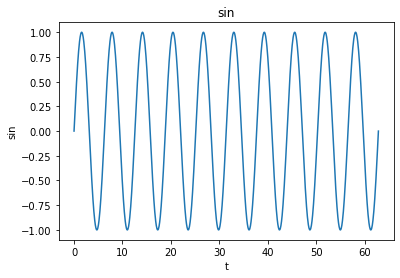

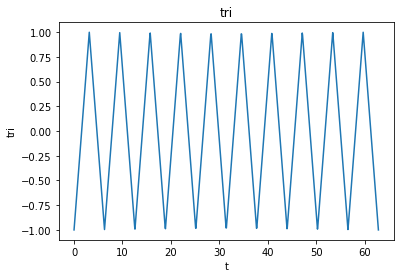

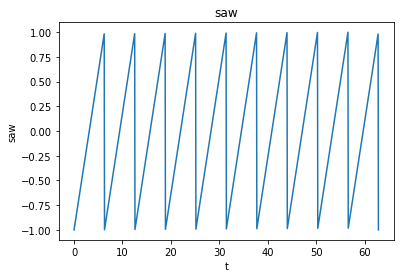

In [5]:
samples = 1000
_, _ = ocilator_gen('sin', 10, 2*np.pi, 0, samples, True)
_, _ = ocilator_gen('tri', 10, 2*np.pi, 0, samples, True)
_, _ = ocilator_gen('saw', 10, 2*np.pi, 0, samples, True)

# Simple RNN

## sin

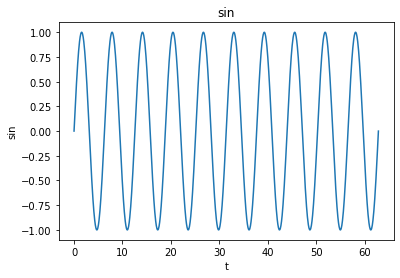

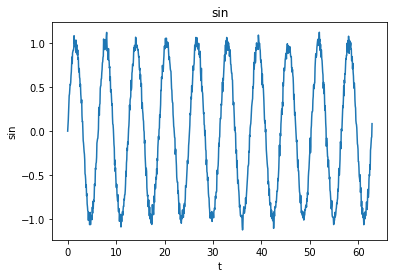

In [ ]:
# add noise
samples = 1000
functype = 'sin'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0065 - val_loss: 0.0012 - 2s/epoch - 4ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0014 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0014 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step



test loss = 0.0014183830935508013


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0817
valid MSE: 0.0769
test MSE: 0.0848


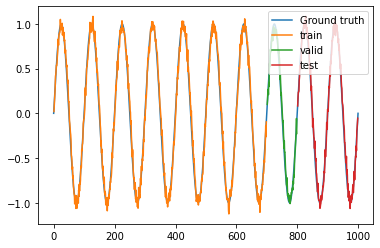

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 225.32192098165478


## tri

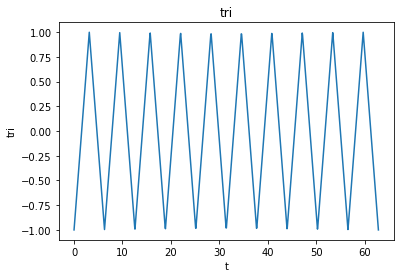

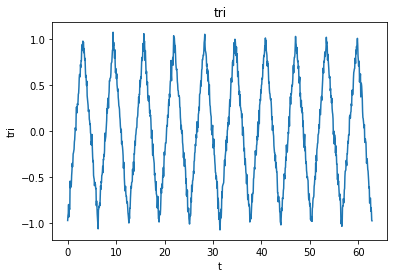

In [ ]:
# add noise
samples = 1000
functype = 'tri'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0954 - val_loss: 0.0130 - 2s/epoch - 3ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0049 - val_loss: 0.0019 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step



test loss = 0.0014501232653856277


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0849
valid MSE: 0.0867
test MSE: 0.0817


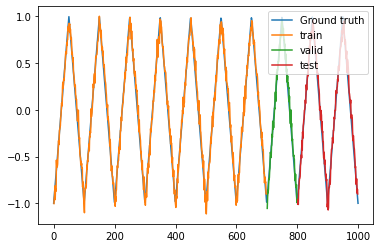

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 317.08057009240486


## saw

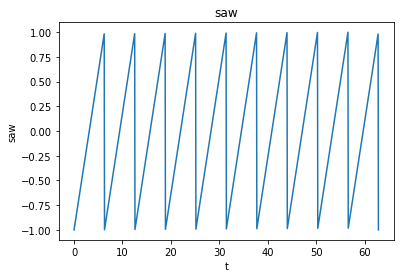

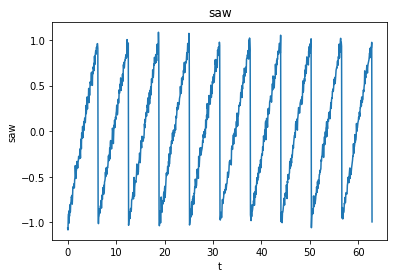

In [ ]:
# add noise
samples = 1000
functype = 'saw'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0472 - val_loss: 0.0052 - 2s/epoch - 3ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0082 - val_loss: 0.0019 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0076 - val_loss: 0.0022 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0076 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0079 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0078 - val_loss: 0.0012 - 1s/epoch - 2ms/step



test loss = 0.004541813861578703


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1861
valid MSE: 0.0751
test MSE: 0.1461


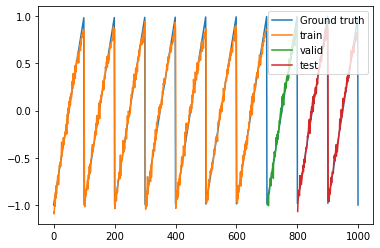

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 552.9355982644704


# LSTM

## sin

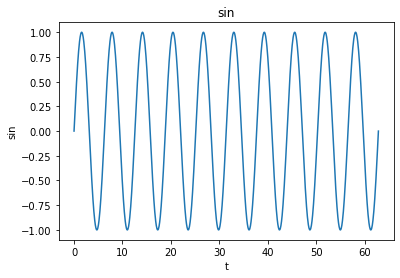

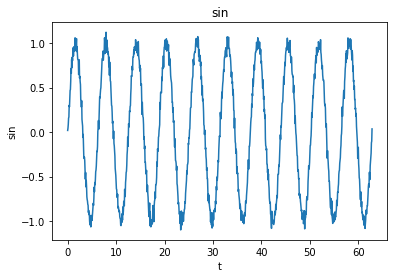

In [ ]:
# add noise
samples = 1000
functype = 'sin'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0605 - val_loss: 0.0106 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 2s - loss: 0.0039 - val_loss: 0.0016 - 2s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 2s - loss: 0.0017 - val_loss: 0.0013 - 2s/epoch - 2ms/step



test loss = 0.0013966313563287258


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0875
valid MSE: 0.0809
test MSE: 0.0830


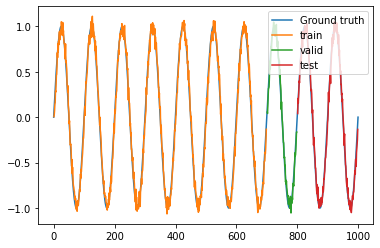

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 537.7191251313174


## tri

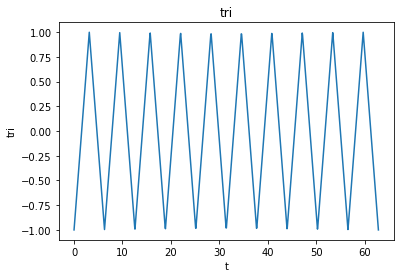

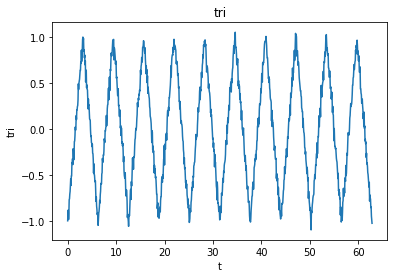

In [ ]:
# add noise
samples = 1000
functype = 'tri'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
689/689 - 4s - loss: 0.0308 - val_loss: 0.0060 - 4s/epoch - 6ms/step
Epoch 2/10
689/689 - 1s - loss: 0.0036 - val_loss: 0.0022 - 1s/epoch - 2ms/step
Epoch 3/10
689/689 - 1s - loss: 0.0015 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 4/10
689/689 - 1s - loss: 0.0013 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 5/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 6/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 7/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 8/10
689/689 - 1s - loss: 0.0011 - val_loss: 9.7820e-04 - 1s/epoch - 2ms/step
Epoch 9/10
689/689 - 1s - loss: 0.0011 - val_loss: 9.7809e-04 - 1s/epoch - 2ms/step
Epoch 10/10
689/689 - 1s - loss: 0.0011 - val_loss: 0.0011 - 1s/epoch - 2ms/step



test loss = 0.0011479281820356846


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0708
valid MSE: 0.0718
test MSE: 0.0727


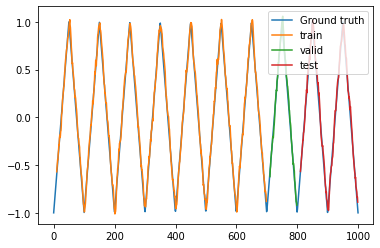

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 641.6999913172956


## saw

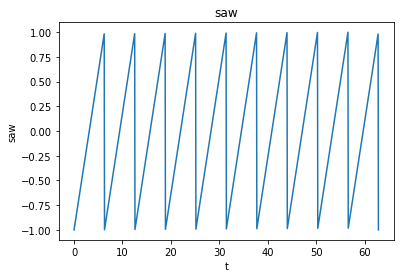

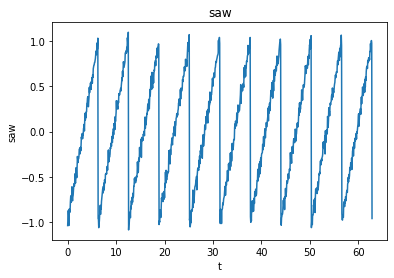

In [ ]:
# add noise
samples = 1000
functype = 'saw'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0664 - val_loss: 0.0175 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0155 - val_loss: 0.0041 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0095 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0087 - val_loss: 0.0047 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0023 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0087 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0086 - val_loss: 0.0011 - 1s/epoch - 2ms/step



test loss = 0.004613384138792753


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1988
valid MSE: 0.0705
test MSE: 0.1477


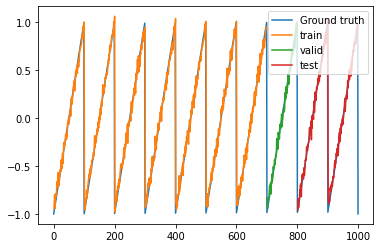

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 1932.3187060644009


# Effect of some hyperparameters on signal

## Variance 

mu =  0.05


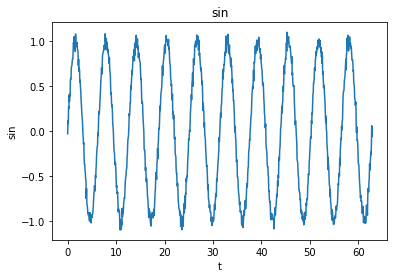

test loss = 0.000936469528824091 

train MSE: 0.0657
valid MSE: 0.0651
test MSE: 0.0674 



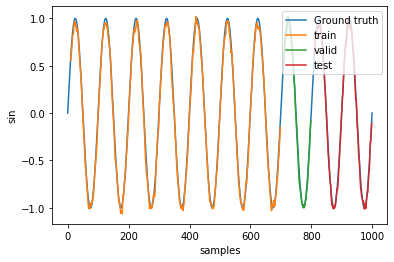

mu =  0.1


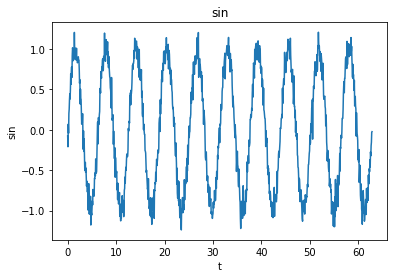

test loss = 0.0029282551258802414 

train MSE: 0.1183
valid MSE: 0.1087
test MSE: 0.1323 



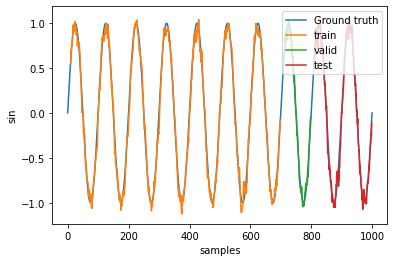

mu =  0.2


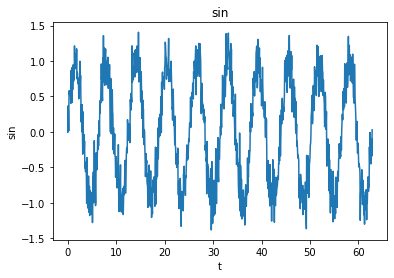

test loss = 0.006826096214354038 

train MSE: 0.2366
valid MSE: 0.2412
test MSE: 0.2304 



mu =  0.3


test loss = 0.010113395750522614 

train MSE: 0.3415
valid MSE: 0.3208
test MSE: 0.3469 



mu =  0.5


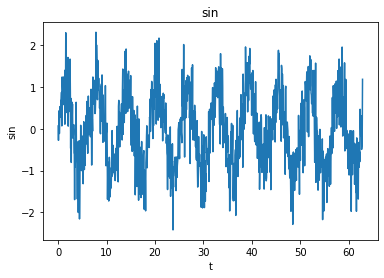

test loss = 0.015178567729890347 

train MSE: 0.5794
valid MSE: 0.5816
test MSE: 0.5831 



In [ ]:
samples = 1000
functype = 'sin'

for sigma in [0.05, 0.1, 0.2, 0.3, 0.5]:
  print('====================================================================')
  print('sigma = ', sigma)
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 10
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

## Learning rate

LR =  0.001


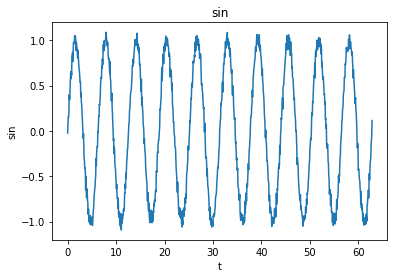

test loss = 0.0016590168233960867 

train MSE: 0.0860
valid MSE: 0.0849
test MSE: 0.0888 



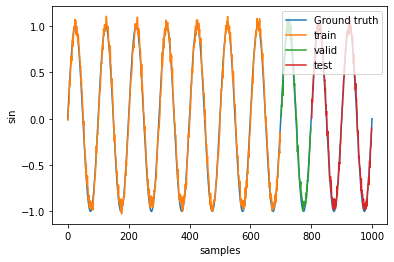

LR =  0.01


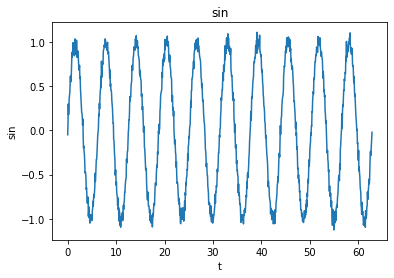

test loss = 0.002317448379471898 

train MSE: 0.1040
valid MSE: 0.0999
test MSE: 0.1075 



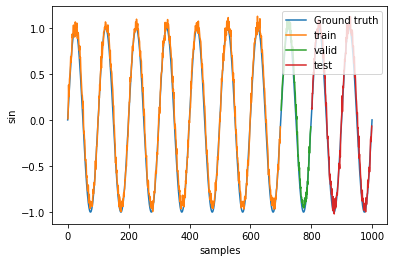

LR =  0.1


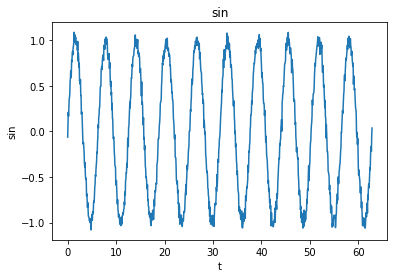

test loss = 0.0067498995922505856 

train MSE: 0.1766
valid MSE: 0.1805
test MSE: 0.1782 



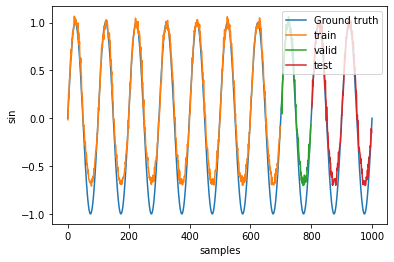

LR =  0.2


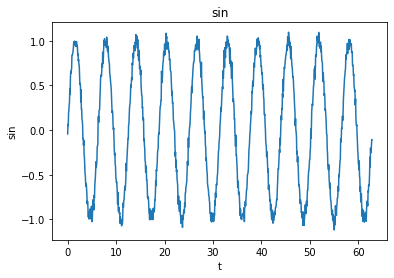

test loss = 0.020542632788419724 

train MSE: 0.3174
valid MSE: 0.3142
test MSE: 0.3176 



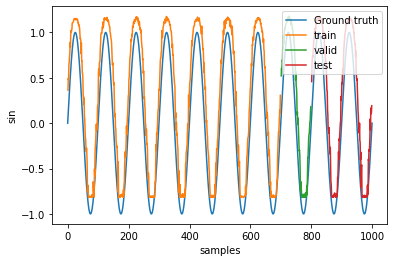

In [ ]:
for LR in [0.001, 0.01, 0.1, 0.2]:
  print('====================================================================')
  print('LR = ', LR)
  mu = 0.05
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=LR)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

## Batch size

batch size =  1


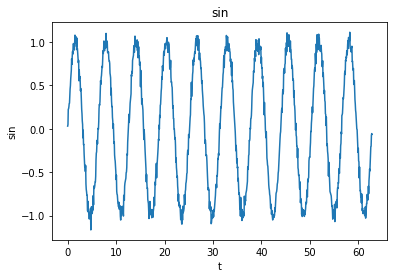

test loss = 0.0014782153302803636 

train MSE: 0.0863
valid MSE: 0.0942
test MSE: 0.0876 



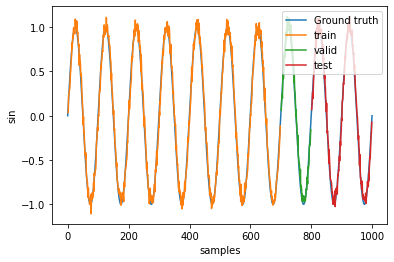

batch size =  10


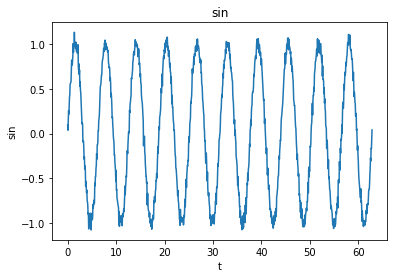

test loss = 0.002791646169498563 

train MSE: 0.1116
valid MSE: 0.1133
test MSE: 0.1165 



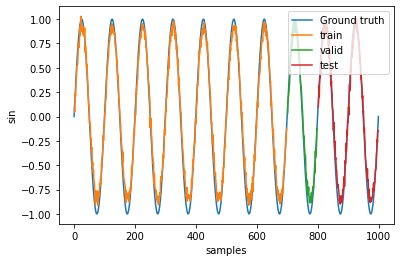

batch size =  30


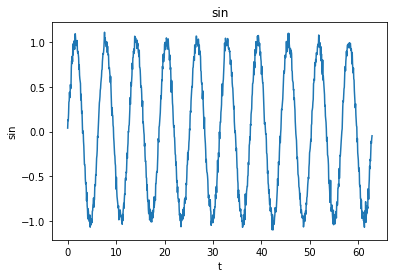

test loss = 0.039389245212078094 

train MSE: 0.4402
valid MSE: 0.4395
test MSE: 0.4387 



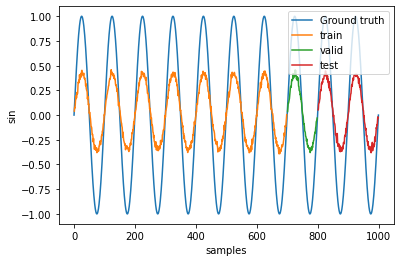

batch size =  50


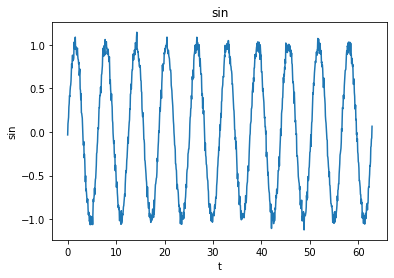

test loss = 0.059338320046663284 

train MSE: 0.5501
valid MSE: 0.5585
test MSE: 0.5519 



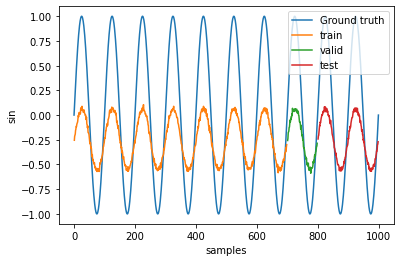

batch size =  100


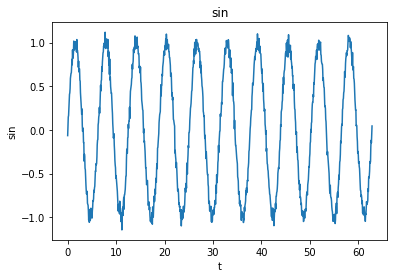

test loss = 0.15922638773918152 

train MSE: 0.9017
valid MSE: 0.9071
test MSE: 0.9042 



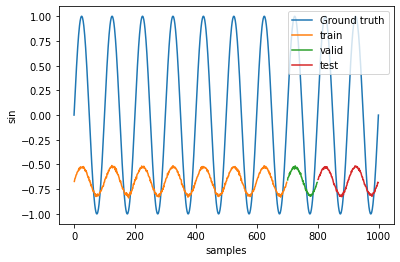

In [ ]:
for batch_size in [1, 10, 30, 50, 100]:
  print('====================================================================')
  print('batch size = ', batch_size)
  mu = 0.05
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=batch_size, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

## Number of epochs

epoch =  1


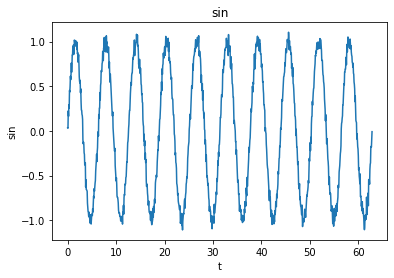

test loss = 0.014593610540032387 

train MSE: 0.2667
valid MSE: 0.2669
test MSE: 0.2674 



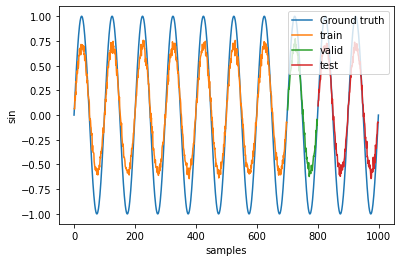

epoch =  5


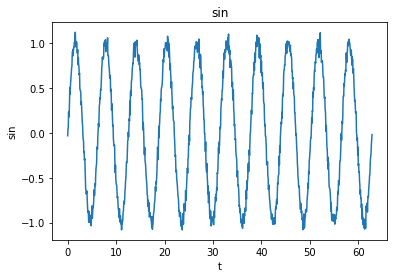

test loss = 0.0014935166109353304 

train MSE: 0.0876
valid MSE: 0.0772
test MSE: 0.0852 



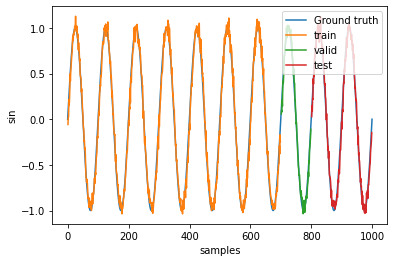

epoch =  10


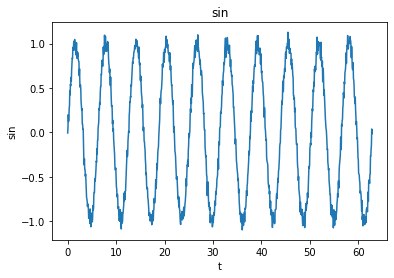

test loss = 0.001802915590815246 

train MSE: 0.0849
valid MSE: 0.0865
test MSE: 0.0945 



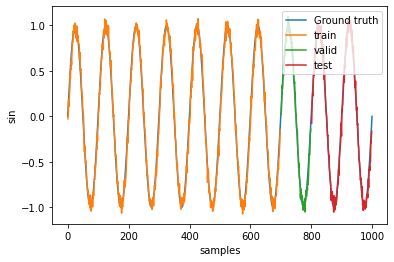

epoch =  20


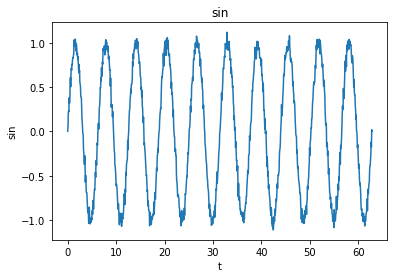

test loss = 0.0015026602195575833 

train MSE: 0.0822
valid MSE: 0.0786
test MSE: 0.0865 



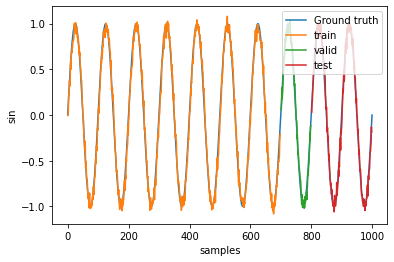

epoch =  30


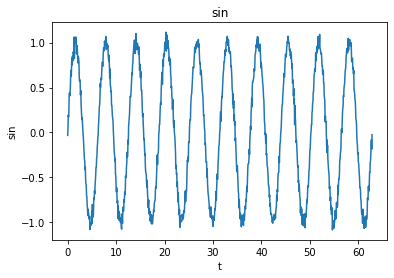

test loss = 0.0014618284767493606 

train MSE: 0.0859
valid MSE: 0.0910
test MSE: 0.0841 



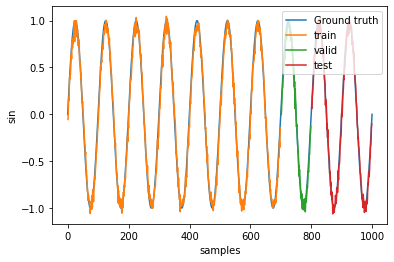

In [ ]:
for epoch in [1, 5, 10, 20, 30]:
  print('====================================================================')
  print('epoch = ', epoch)
  mu = 0.05
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=epoch, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

# Non-White noise

## Loopback = 1

Text(0.5, 1.0, 'noise')

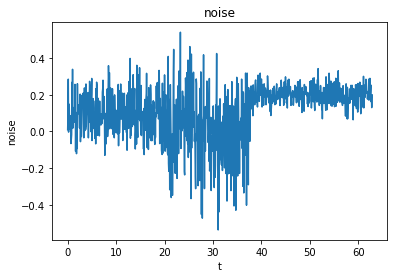

In [ ]:
# Create Non-White noise 
mu1 = 0.1
mu2 = 0
mu3 = 0.2

sigma1 = 0.1
sigma2 = 0.2
sigma3 = 0.05

arrays=[
    np.random.normal(mu1,sigma1,300),
    np.random.normal(mu2,sigma2,300),
    np.random.normal(mu3,sigma3,400)
]

# Create an array to return to
noise = np.array([])

for array in arrays:
    noise = np.concatenate([noise, array])

plt.plot(xaxis, noise)
plt.xlabel('t')
plt.ylabel('noise')
plt.title('noise')

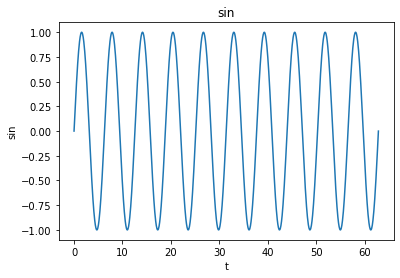

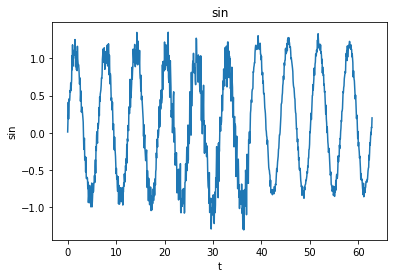

In [ ]:
# add noise
samples = 1000
functype = 'sin'
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0888 - val_loss: 0.0219 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0155 - val_loss: 0.0043 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0069 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0060 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0060 - val_loss: 8.8286e-04 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0060 - val_loss: 8.8335e-04 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0060 - val_loss: 8.8384e-04 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0060 - val_loss: 9.8082e-04 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0059 - val_loss: 9.7654e-04 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0061 - val_loss: 9.1269e-04 - 1s/epoch - 2ms/step



test loss = 0.0011284711072221398


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.2023
valid MSE: 0.0804
test MSE: 0.0895


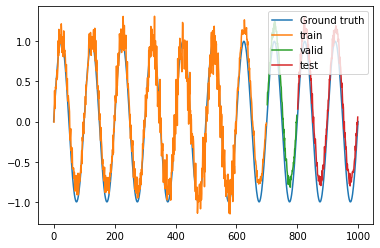

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 119.52882044799928


## Loopback = 10

Text(0.5, 1.0, 'noise')

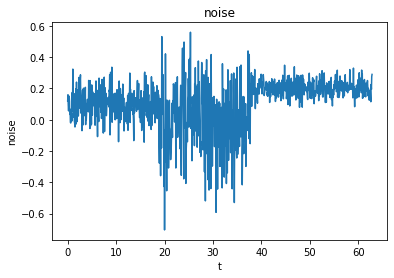

In [ ]:
# Create Non-White noise 
mu1 = 0.1
mu2 = 0
mu3 = 0.2

sigma1 = 0.1
sigma2 = 0.2
sigma3 = 0.05

arrays=[
    np.random.normal(mu1,sigma1,300),
    np.random.normal(mu2,sigma2,300),
    np.random.normal(mu3,sigma3,400)
]

# Create an array to return to
noise = np.array([])

for array in arrays:
    noise = np.concatenate([noise, array])

plt.plot(xaxis, noise)
plt.xlabel('t')
plt.ylabel('noise')
plt.title('noise')

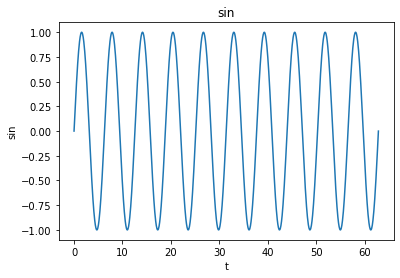

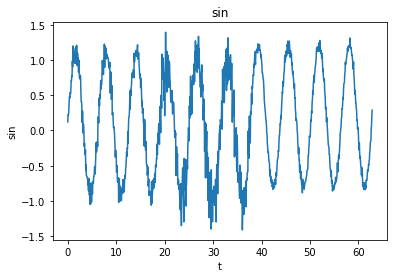

In [ ]:
# add noise
samples = 1000
functype = 'sin'
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
689/689 - 3s - loss: 0.0360 - val_loss: 0.0048 - 3s/epoch - 5ms/step
Epoch 2/10
689/689 - 1s - loss: 0.0058 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 3/10
689/689 - 1s - loss: 0.0048 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 4/10
689/689 - 1s - loss: 0.0046 - val_loss: 7.1134e-04 - 1s/epoch - 2ms/step
Epoch 5/10
689/689 - 1s - loss: 0.0045 - val_loss: 6.5986e-04 - 1s/epoch - 2ms/step
Epoch 6/10
689/689 - 1s - loss: 0.0045 - val_loss: 7.0206e-04 - 1s/epoch - 2ms/step
Epoch 7/10
689/689 - 1s - loss: 0.0045 - val_loss: 8.6790e-04 - 1s/epoch - 2ms/step
Epoch 8/10
689/689 - 1s - loss: 0.0043 - val_loss: 0.0024 - 1s/epoch - 2ms/step
Epoch 9/10
689/689 - 1s - loss: 0.0044 - val_loss: 7.2921e-04 - 1s/epoch - 2ms/step
Epoch 10/10
689/689 - 1s - loss: 0.0045 - val_loss: 9.4139e-04 - 1s/epoch - 2ms/step



test loss = 0.0008122880244627595


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1810
valid MSE: 0.0861
test MSE: 0.0800


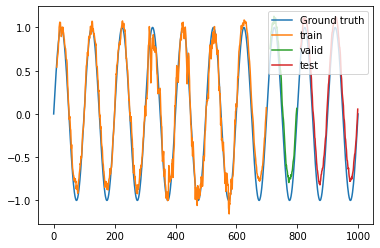

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 450.466434688481


# 2D-Space

## Circle


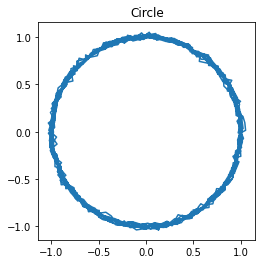

In [258]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)

x = np.cos(t)
y = np.sin(t)

# Add noise
sigma = 0.02
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise

figure, axes = plt.subplots(1)
 
plt.plot(x, y)
axes.set_aspect(1)
 
plt.title('Circle')
plt.show()

In [259]:
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
dataset.head()

x         y
0  0.996601 -0.005954
1  0.984798  0.087493
2  0.982554  0.093112
3  0.983568  0.148952
4  0.947180  0.264926

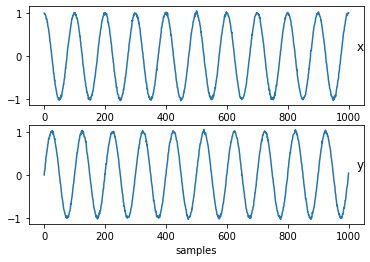

In [260]:
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	plt.xlabel('samples')
	i += 1
plt.show()

In [261]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

variable_1(t-1)  variable_2(t-1)  variable_1(t)  variable_2(t)
1         0.973580         0.493713       0.967919       0.538439
2         0.967919         0.538439       0.966843       0.541128
3         0.966843         0.541128       0.967329       0.567854
4         0.967329         0.567854       0.949878       0.623361
5         0.949878         0.623361       0.946377       0.639871

In [262]:
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print('train x shape = ', train_x.shape)
print('valid x shape = ', valid_x.shape)
print('test x shape  = ', test_x.shape)

train x shape =  (699, 1, 2)
valid x shape =  (99, 1, 2)
test x shape  =  (201, 1, 2)


### 1.SimpleRNN

Epoch 1/100
10/10 - 1s - loss: 0.3130 - val_loss: 0.2164 - 1s/epoch - 104ms/step
Epoch 2/100
10/10 - 0s - loss: 0.1677 - val_loss: 0.1124 - 44ms/epoch - 4ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0886 - val_loss: 0.0642 - 39ms/epoch - 4ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0552 - val_loss: 0.0465 - 51ms/epoch - 5ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0424 - val_loss: 0.0377 - 41ms/epoch - 4ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0341 - val_loss: 0.0299 - 47ms/epoch - 5ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0266 - val_loss: 0.0232 - 48ms/epoch - 5ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0207 - val_loss: 0.0182 - 43ms/epoch - 4ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0164 - val_loss: 0.0144 - 44ms/epoch - 4ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0130 - val_loss: 0.0115 - 49ms/epoch - 5ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0104 - val_loss: 0.0092 - 48ms/epoch - 5ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0084 - val_loss: 0.0075 - 45ms/epoch - 5ms/step
Epoch 13/100
10/10 - 0s -

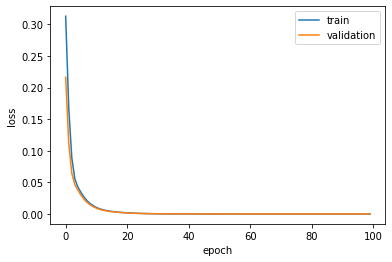




test loss = 0.000201581628061831


In [263]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_x.shape[1], train_X.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)

In [264]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.029
valid MSE: 0.029
test MSE: 0.030


In [265]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Circle')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))


 SNR = 966.0492330473209


### 2.LSTM

Epoch 1/100
10/10 - 3s - loss: 0.3553 - val_loss: 0.3268 - 3s/epoch - 297ms/step
Epoch 2/100
10/10 - 0s - loss: 0.3092 - val_loss: 0.2834 - 57ms/epoch - 6ms/step
Epoch 3/100
10/10 - 0s - loss: 0.2669 - val_loss: 0.2429 - 49ms/epoch - 5ms/step
Epoch 4/100
10/10 - 0s - loss: 0.2273 - val_loss: 0.2048 - 47ms/epoch - 5ms/step
Epoch 5/100
10/10 - 0s - loss: 0.1900 - val_loss: 0.1693 - 58ms/epoch - 6ms/step
Epoch 6/100
10/10 - 0s - loss: 0.1556 - val_loss: 0.1372 - 52ms/epoch - 5ms/step
Epoch 7/100
10/10 - 0s - loss: 0.1254 - val_loss: 0.1100 - 50ms/epoch - 5ms/step
Epoch 8/100
10/10 - 0s - loss: 0.1005 - val_loss: 0.0888 - 50ms/epoch - 5ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0818 - val_loss: 0.0738 - 55ms/epoch - 6ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0692 - val_loss: 0.0643 - 56ms/epoch - 6ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0613 - val_loss: 0.0584 - 50ms/epoch - 5ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0563 - val_loss: 0.0544 - 51ms/epoch - 5ms/step
Epoch 13/100
10/10 - 0s -

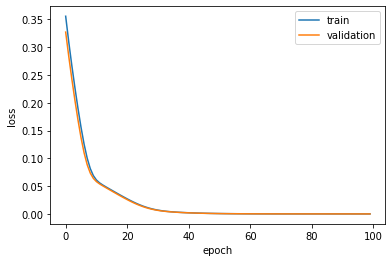




test loss = 0.000463882606709376


In [266]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_X.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)
noise = np.random.normal(0,sigma,samples)

In [267]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.044
valid MSE: 0.044
test MSE: 0.045


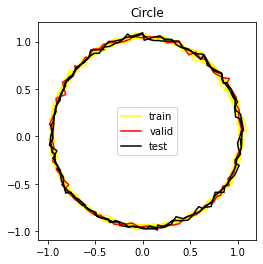


 SNR = 543.576667917851


In [268]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Circle')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

## Epidrochoid


In [225]:
samples = 10000
t = np.linspace(0, 10*2*np.pi, samples)
a = c = 5
b = 3

x = (a + b) * np.cos(t) - c * np.cos((a/b+1) * t)
y = (a + b) * np.sin(t) - c * np.sin((a/b+1) * t)

# Add noise
sigma = 0.1
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise

figure, axes = plt.subplots(1)
 
plt.plot(x, y)
axes.set_aspect(1)
 
plt.title('Epidrochoid')
plt.show()

In [226]:
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
dataset.head()

x         y
0  2.879658 -0.127195
1  2.836892 -0.191898
2  2.860683 -0.057324
3  2.951243 -0.112554
4  3.120337 -0.207377

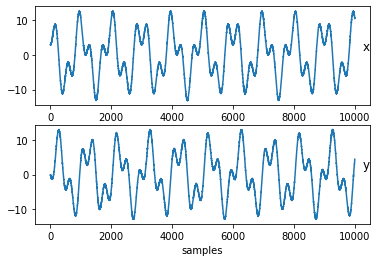

In [227]:
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	plt.xlabel('samples')
	i += 1
plt.show()

In [228]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

variable_1(t-1)  variable_2(t-1)  variable_1(t)  variable_2(t)
1         0.620730         0.493717       0.619079       0.491232
2         0.619079         0.491232       0.619998       0.496402
3         0.619998         0.496402       0.623494       0.494280
4         0.623494         0.494280       0.630023       0.490637
5         0.630023         0.490637       0.627917       0.496329

In [229]:
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print('train x shape = ', train_x.shape)
print('valid x shape = ', valid_x.shape)
print('test x shape  = ', test_x.shape)

train x shape =  (6999, 1, 2)
valid x shape =  (999, 1, 2)
test x shape  =  (2001, 1, 2)


### 1.SimpleRNN

Epoch 1/100
98/98 - 1s - loss: 0.0704 - val_loss: 0.0250 - 1s/epoch - 12ms/step
Epoch 2/100
98/98 - 0s - loss: 0.0186 - val_loss: 0.0071 - 213ms/epoch - 2ms/step
Epoch 3/100
98/98 - 0s - loss: 0.0047 - val_loss: 0.0014 - 221ms/epoch - 2ms/step
Epoch 4/100
98/98 - 0s - loss: 9.9155e-04 - val_loss: 3.0886e-04 - 259ms/epoch - 3ms/step
Epoch 5/100
98/98 - 0s - loss: 2.7334e-04 - val_loss: 1.0167e-04 - 223ms/epoch - 2ms/step
Epoch 6/100
98/98 - 0s - loss: 1.1091e-04 - val_loss: 5.3959e-05 - 219ms/epoch - 2ms/step
Epoch 7/100
98/98 - 0s - loss: 6.5522e-05 - val_loss: 4.5494e-05 - 213ms/epoch - 2ms/step
Epoch 8/100
98/98 - 0s - loss: 5.3996e-05 - val_loss: 4.5849e-05 - 207ms/epoch - 2ms/step
Epoch 9/100
98/98 - 0s - loss: 5.1667e-05 - val_loss: 4.6970e-05 - 217ms/epoch - 2ms/step
Epoch 10/100
98/98 - 0s - loss: 5.1430e-05 - val_loss: 4.7569e-05 - 230ms/epoch - 2ms/step
Epoch 11/100
98/98 - 0s - loss: 5.1609e-05 - val_loss: 4.7811e-05 - 251ms/epoch - 3ms/step
Epoch 12/100
98/98 - 0s - loss: 5.

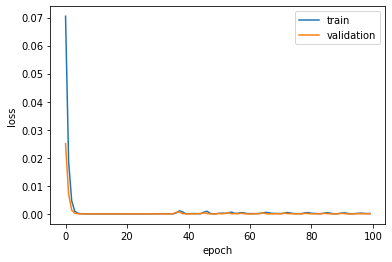




test loss = 7.406009535770863e-05


In [230]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_x.shape[1], train_X.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)

In [231]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.224
valid MSE: 0.220
test MSE: 0.223


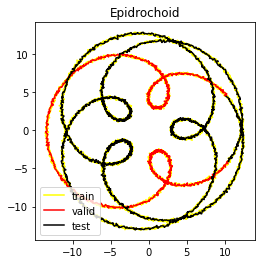


 SNR = 4375.329876952525


In [232]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Epidrochoid')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

### 2.LSTM

Epoch 1/100
98/98 - 3s - loss: 0.1626 - val_loss: 0.0412 - 3s/epoch - 29ms/step
Epoch 2/100
98/98 - 0s - loss: 0.0384 - val_loss: 0.0277 - 331ms/epoch - 3ms/step
Epoch 3/100
98/98 - 0s - loss: 0.0298 - val_loss: 0.0215 - 319ms/epoch - 3ms/step
Epoch 4/100
98/98 - 0s - loss: 0.0220 - val_loss: 0.0150 - 340ms/epoch - 3ms/step
Epoch 5/100
98/98 - 0s - loss: 0.0142 - val_loss: 0.0089 - 341ms/epoch - 3ms/step
Epoch 6/100
98/98 - 0s - loss: 0.0076 - val_loss: 0.0044 - 302ms/epoch - 3ms/step
Epoch 7/100
98/98 - 0s - loss: 0.0034 - val_loss: 0.0019 - 310ms/epoch - 3ms/step
Epoch 8/100
98/98 - 0s - loss: 0.0014 - val_loss: 9.2326e-04 - 297ms/epoch - 3ms/step
Epoch 9/100
98/98 - 0s - loss: 7.2685e-04 - val_loss: 5.3554e-04 - 293ms/epoch - 3ms/step
Epoch 10/100
98/98 - 0s - loss: 4.4222e-04 - val_loss: 3.5219e-04 - 317ms/epoch - 3ms/step
Epoch 11/100
98/98 - 0s - loss: 3.0538e-04 - val_loss: 2.5719e-04 - 295ms/epoch - 3ms/step
Epoch 12/100
98/98 - 0s - loss: 2.3793e-04 - val_loss: 2.0795e-04 - 34

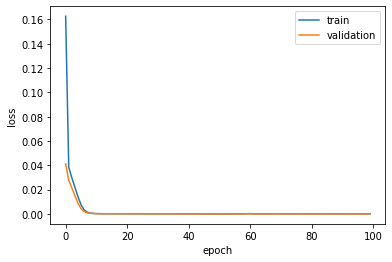




test loss = 5.691040132660419e-05


In [233]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_X.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)
noise = np.random.normal(0,sigma,samples)

In [234]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.195
valid MSE: 0.185
test MSE: 0.196


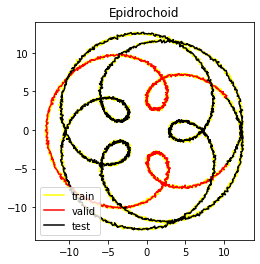


 SNR = 9164.711280736012


In [235]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Epidrochoid')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

## Nephroid


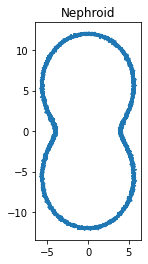

In [236]:
samples = 10000
t = np.linspace(0, 10*2*np.pi, samples)
a = 2

x = a * (np.cos(3 * t) - 3 * np.cos(t))
y = a * (np.sin(3 * t) - c * np.sin(t))

# Add noise
sigma = 0.1
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise

figure, axes = plt.subplots(1)
 
plt.plot(x, y)
axes.set_aspect(1)
 
plt.title('Nephroid')
plt.show()

In [237]:
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
dataset.head()

x         y
0 -4.100596 -0.021266
1 -3.964221 -0.159717
2 -3.897450 -0.036036
3 -3.928568 -0.137272
4 -3.878414 -0.141651

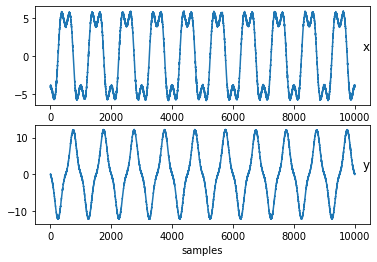

In [238]:
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	plt.xlabel('samples')
	i += 1
plt.show()

In [239]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

variable_1(t-1)  variable_2(t-1)  variable_1(t)  variable_2(t)
1         0.153397         0.499427       0.164875       0.493752
2         0.164875         0.493752       0.170494       0.498821
3         0.170494         0.498821       0.167876       0.494672
4         0.167876         0.494672       0.172097       0.494493
5         0.172097         0.494493       0.141036       0.491852

In [240]:
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print('train x shape = ', train_x.shape)
print('valid x shape = ', valid_x.shape)
print('test x shape  = ', test_x.shape)

train x shape =  (6999, 1, 2)
valid x shape =  (999, 1, 2)
test x shape  =  (2001, 1, 2)


### 1.SimpleRNN

Epoch 1/100
98/98 - 1s - loss: 0.0874 - val_loss: 0.0268 - 1s/epoch - 13ms/step
Epoch 2/100
98/98 - 0s - loss: 0.0133 - val_loss: 0.0042 - 259ms/epoch - 3ms/step
Epoch 3/100
98/98 - 0s - loss: 0.0022 - val_loss: 8.4132e-04 - 253ms/epoch - 3ms/step
Epoch 4/100
98/98 - 0s - loss: 5.3795e-04 - val_loss: 2.6379e-04 - 254ms/epoch - 3ms/step
Epoch 5/100
98/98 - 0s - loss: 1.9107e-04 - val_loss: 1.3059e-04 - 276ms/epoch - 3ms/step
Epoch 6/100
98/98 - 0s - loss: 1.1405e-04 - val_loss: 1.0639e-04 - 218ms/epoch - 2ms/step
Epoch 7/100
98/98 - 0s - loss: 1.0112e-04 - val_loss: 1.0325e-04 - 245ms/epoch - 2ms/step
Epoch 8/100
98/98 - 0s - loss: 9.9578e-05 - val_loss: 1.0298e-04 - 204ms/epoch - 2ms/step
Epoch 9/100
98/98 - 0s - loss: 9.9494e-05 - val_loss: 1.0295e-04 - 206ms/epoch - 2ms/step
Epoch 10/100
98/98 - 0s - loss: 9.9545e-05 - val_loss: 1.0293e-04 - 222ms/epoch - 2ms/step
Epoch 11/100
98/98 - 0s - loss: 9.9603e-05 - val_loss: 1.0291e-04 - 250ms/epoch - 3ms/step
Epoch 12/100
98/98 - 0s - loss

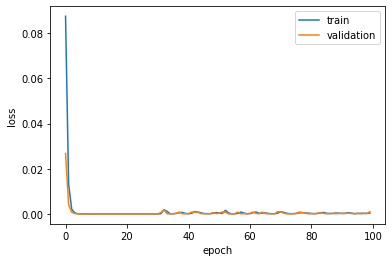




test loss = 0.0010634608333930373


In [241]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_x.shape[1], train_X.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)

In [242]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.599
valid MSE: 0.600
test MSE: 0.599


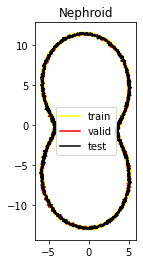


 SNR = 2895.961878067108


In [243]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Nephroid')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

### 2.LSTM

Epoch 1/100
98/98 - 3s - loss: 0.2328 - val_loss: 0.1059 - 3s/epoch - 28ms/step
Epoch 2/100
98/98 - 0s - loss: 0.0619 - val_loss: 0.0413 - 322ms/epoch - 3ms/step
Epoch 3/100
98/98 - 0s - loss: 0.0328 - val_loss: 0.0228 - 282ms/epoch - 3ms/step
Epoch 4/100
98/98 - 0s - loss: 0.0166 - val_loss: 0.0105 - 316ms/epoch - 3ms/step
Epoch 5/100
98/98 - 0s - loss: 0.0079 - val_loss: 0.0055 - 305ms/epoch - 3ms/step
Epoch 6/100
98/98 - 0s - loss: 0.0045 - val_loss: 0.0033 - 290ms/epoch - 3ms/step
Epoch 7/100
98/98 - 0s - loss: 0.0027 - val_loss: 0.0020 - 291ms/epoch - 3ms/step
Epoch 8/100
98/98 - 0s - loss: 0.0017 - val_loss: 0.0012 - 290ms/epoch - 3ms/step
Epoch 9/100
98/98 - 0s - loss: 0.0010 - val_loss: 7.6888e-04 - 289ms/epoch - 3ms/step
Epoch 10/100
98/98 - 0s - loss: 6.6554e-04 - val_loss: 5.4937e-04 - 276ms/epoch - 3ms/step
Epoch 11/100
98/98 - 0s - loss: 5.0344e-04 - val_loss: 4.5008e-04 - 293ms/epoch - 3ms/step
Epoch 12/100
98/98 - 0s - loss: 4.3233e-04 - val_loss: 4.0648e-04 - 281ms/epoc

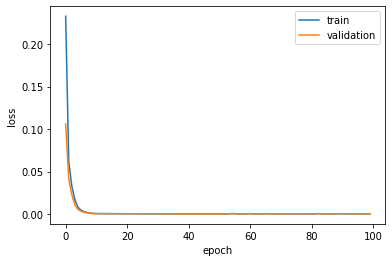




test loss = 0.00036154291592538357


In [244]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_X.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)
noise = np.random.normal(0,sigma,samples)

In [245]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.247
valid MSE: 0.249
test MSE: 0.248


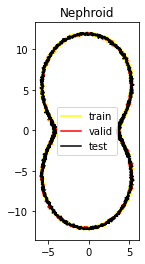


 SNR = 7121.29773439975


In [246]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Nephroid')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

## Effect of some hyperparameters on 2D-signals


### Variance

sigma =  0.02


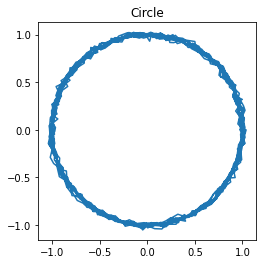

train loss =  0.000405429134843871
valid loss =  0.00037851821980439126
test loss =  0.00040436573908664286

 train MSE: 0.042
valid MSE: 0.040
test MSE: 0.042



 SNR = 807.4370635533213
sigma =  0.05


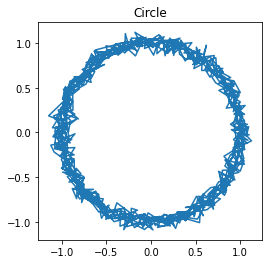

train loss =  0.0013444687938317657
valid loss =  0.001113924547098577
test loss =  0.0013077650219202042

 train MSE: 0.082
valid MSE: 0.075
test MSE: 0.081


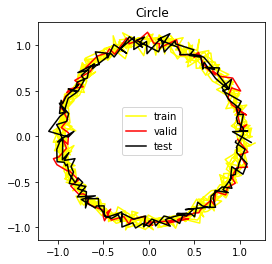


 SNR = 674.9520384854796
sigma =  0.1


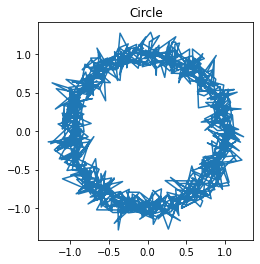

train loss =  0.0037167563568800688
valid loss =  0.003781781066209078
test loss =  0.003611297346651554

 train MSE: 0.155
valid MSE: 0.157
test MSE: 0.153


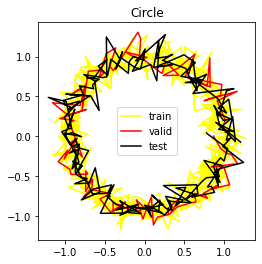


 SNR = 249.936049432134
sigma =  0.2


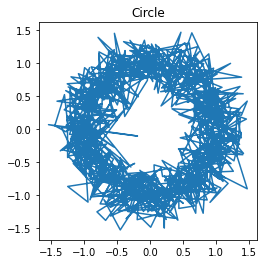

train loss =  0.010982098057866096
valid loss =  0.012610744684934616
test loss =  0.011129215359687805

 train MSE: 0.314
valid MSE: 0.336
test MSE: 0.316


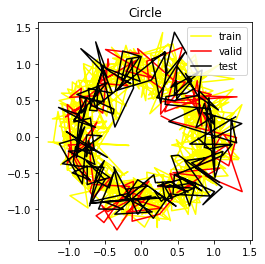


 SNR = 240.01828548639347
sigma =  0.3


train loss =  0.014905096031725407
valid loss =  0.01785936765372753
test loss =  0.014982691034674644

 train MSE: 0.498
valid MSE: 0.548
test MSE: 0.500


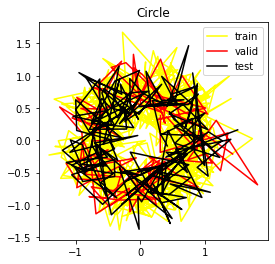


 SNR = 160.78509789291886
sigma =  0.5


train loss =  0.024994589388370514
valid loss =  0.02422158420085907
test loss =  0.024997659027576447

 train MSE: 0.768
valid MSE: 0.756
test MSE: 0.771


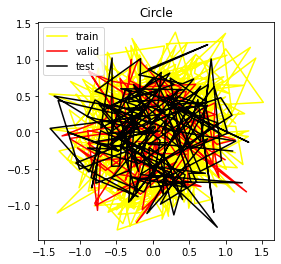


 SNR = 67.02810109622095


In [281]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)
x = np.cos(t)
y = np.sin(t)
for sigma in [0.02, 0.05, 0.1, 0.2, 0.3, 0.5]:
  print('====================================================================')
  print('sigma = ', sigma)
  # Add noise
  noise = np.random.normal(0,sigma,samples)
  x = x + noise
  noise = np.random.normal(0,sigma,samples)
  y = y + noise
  figure, axes = plt.subplots(1)
  plt.plot(x, y)
  axes.set_aspect(1)
  plt.title('Circle')
  plt.show()
  # create dataframe
  data = np.array([x, y])
  dataset = pd.DataFrame({'x': x, 'y': y})
  values = dataset.values
  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # split into train and test sets
  values = reframed.values
  le = int(len(reframed.columns)/2)
  train_size = int(reframed.values.shape[0] * 0.7)
  valid_size = int(reframed.values.shape[0] * 0.1)
  test_size = reframed.values.shape[0] - train_size - valid_size
  train = values[0:train_size, :]
  valid = values[train_size:train_size+valid_size,:]
  test = values[train_size+valid_size:, :]
  # split into input and outputs
  train_x, train_y = train[:, :le], train[:, le:]
  valid_x, valid_y = valid[:, :le], valid[:, le:]
  test_x, test_y = test[:, :le], test[:, le:]
  # reshape input to be 3D [samples, timesteps, features]
  train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
  valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
  test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_x.shape[1], train_X.shape[2])))
  model.add(Dense(le))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=0, shuffle=False)
  score = model.evaluate(test_x, test_y, verbose=0)
  print('train loss = ', history.history['loss'][-1])
  print('valid loss = ', history.history['val_loss'][-1])
  print('test loss = ', score)
  # make predictions
  trainPredict = model.predict(train_x)
  validPredict = model.predict(valid_x)
  testPredict = model.predict(test_x)
  train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
  valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
  test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
  # invert scaling for forecast
  inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
  inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
  inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
  inv_validPredict = scaler.inverse_transform(inv_validPredict)
  inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
  inv_testPredict = scaler.inverse_transform(inv_testPredict)
  # invert scaling for actual
  inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
  inv_train = scaler.inverse_transform(inv_train)
  inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
  inv_valid = scaler.inverse_transform(inv_valid)
  inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
  inv_test = scaler.inverse_transform(inv_test)
  # calculate MSE
  mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
  print('\n train MSE: %.3f' % mse1)
  mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
  print('valid MSE: %.3f' % mse2)
  mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
  print('test MSE: %.3f' % mse3)
  # plot baseline and predictions
  figure, axes = plt.subplots(1)
  plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
  plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
  plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
  axes.set_aspect(1)
  plt.title('Circle')
  plt.legend()
  plt.show()
  print('\n SNR =', snr_f(x, noise, 2*np.pi))

### Learning rate

sigma =  0.02


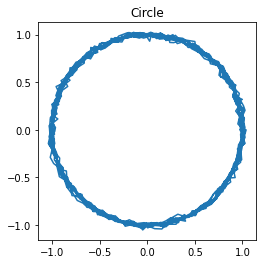

train loss =  0.000405429134843871
valid loss =  0.00037851821980439126
test loss =  0.00040436573908664286

 train MSE: 0.042
valid MSE: 0.040
test MSE: 0.042


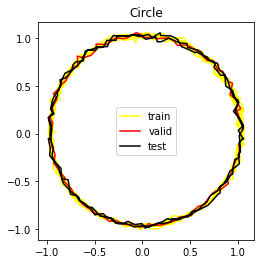


 SNR = 807.4370635533213
sigma =  0.05


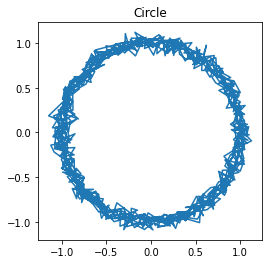

train loss =  0.0013444687938317657
valid loss =  0.001113924547098577
test loss =  0.0013077650219202042

 train MSE: 0.082
valid MSE: 0.075
test MSE: 0.081


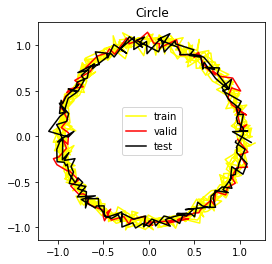


 SNR = 674.9520384854796
sigma =  0.1


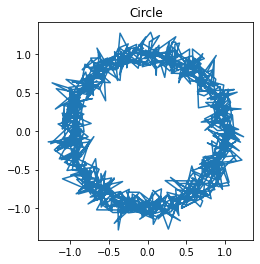

train loss =  0.0037167563568800688
valid loss =  0.003781781066209078
test loss =  0.003611297346651554

 train MSE: 0.155
valid MSE: 0.157
test MSE: 0.153


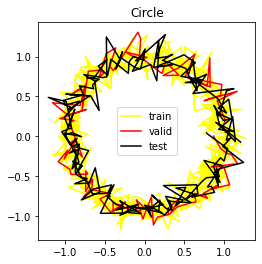


 SNR = 249.936049432134
sigma =  0.2


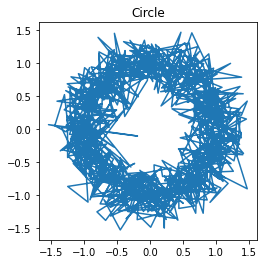

train loss =  0.010982098057866096
valid loss =  0.012610744684934616
test loss =  0.011129215359687805

 train MSE: 0.314
valid MSE: 0.336
test MSE: 0.316


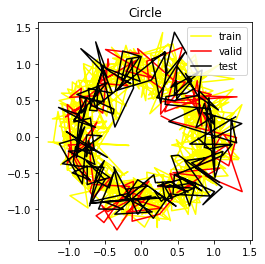


 SNR = 240.01828548639347
sigma =  0.3


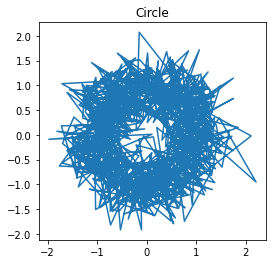

train loss =  0.014905096031725407
valid loss =  0.01785936765372753
test loss =  0.014982691034674644

 train MSE: 0.498
valid MSE: 0.548
test MSE: 0.500


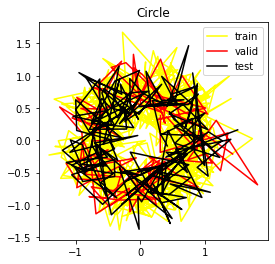


 SNR = 160.78509789291886
sigma =  0.5


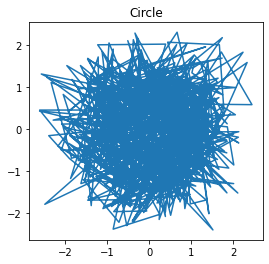

train loss =  0.024994589388370514
valid loss =  0.02422158420085907
test loss =  0.024997659027576447

 train MSE: 0.768
valid MSE: 0.756
test MSE: 0.771


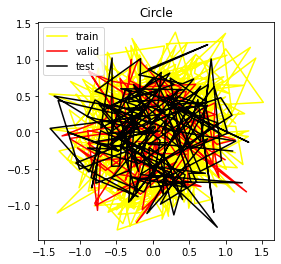


 SNR = 67.02810109622095


In [ ]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)
x = np.cos(t)
y = np.sin(t)
for LR in [0.001, 0.01, 0.1, 0.2]:
  print('====================================================================')
  print('LR = ', LR)
  # Add noise
  sigma = 0.02
  noise = np.random.normal(0,sigma,samples)
  x = x + noise
  noise = np.random.normal(0,sigma,samples)
  y = y + noise
  figure, axes = plt.subplots(1)
  plt.plot(x, y)
  axes.set_aspect(1)
  plt.title('Circle')
  plt.show()
  # create dataframe
  data = np.array([x, y])
  dataset = pd.DataFrame({'x': x, 'y': y})
  values = dataset.values
  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # split into train and test sets
  values = reframed.values
  le = int(len(reframed.columns)/2)
  train_size = int(reframed.values.shape[0] * 0.7)
  valid_size = int(reframed.values.shape[0] * 0.1)
  test_size = reframed.values.shape[0] - train_size - valid_size
  train = values[0:train_size, :]
  valid = values[train_size:train_size+valid_size,:]
  test = values[train_size+valid_size:, :]
  # split into input and outputs
  train_x, train_y = train[:, :le], train[:, le:]
  valid_x, valid_y = valid[:, :le], valid[:, le:]
  test_x, test_y = test[:, :le], test[:, le:]
  # reshape input to be 3D [samples, timesteps, features]
  train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
  valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
  test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_x.shape[1], train_X.shape[2])))
  model.add(Dense(le))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=0, shuffle=False)
  score = model.evaluate(test_x, test_y, verbose=0)
  print('train loss = ', history.history['loss'][-1])
  print('valid loss = ', history.history['val_loss'][-1])
  print('test loss = ', score)
  # make predictions
  trainPredict = model.predict(train_x)
  validPredict = model.predict(valid_x)
  testPredict = model.predict(test_x)
  train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
  valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
  test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
  # invert scaling for forecast
  inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
  inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
  inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
  inv_validPredict = scaler.inverse_transform(inv_validPredict)
  inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
  inv_testPredict = scaler.inverse_transform(inv_testPredict)
  # invert scaling for actual
  inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
  inv_train = scaler.inverse_transform(inv_train)
  inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
  inv_valid = scaler.inverse_transform(inv_valid)
  inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
  inv_test = scaler.inverse_transform(inv_test)
  # calculate MSE
  mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
  print('\n train MSE: %.3f' % mse1)
  mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
  print('valid MSE: %.3f' % mse2)
  mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
  print('test MSE: %.3f' % mse3)
  # plot baseline and predictions
  figure, axes = plt.subplots(1)
  plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
  plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
  plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
  axes.set_aspect(1)
  plt.title('Circle')
  plt.legend()
  plt.show()
  print('\n SNR =', snr_f(x, noise, 2*np.pi))

# Voice

In [39]:
! pip install gTTS

In [41]:
from gtts import gTTS
import os
tts = gTTS(text='Hello. good morning. I want to talk to you about an important topic.', lang='en')
tts.save("good.mp3")
os.system("mpg321 good.mp3")

32512

In [42]:
tts

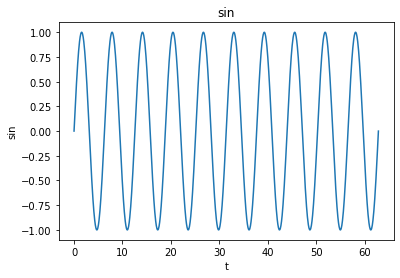

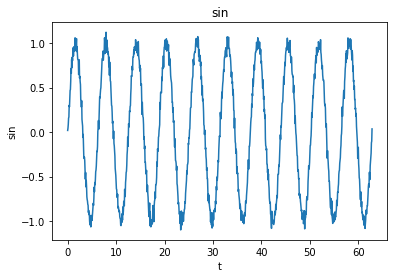

In [ ]:
# add noise
samples = 1000
functype = 'sin'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0605 - val_loss: 0.0106 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 2s - loss: 0.0039 - val_loss: 0.0016 - 2s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 2s - loss: 0.0017 - val_loss: 0.0013 - 2s/epoch - 2ms/step



test loss = 0.0013966313563287258


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0875
valid MSE: 0.0809
test MSE: 0.0830


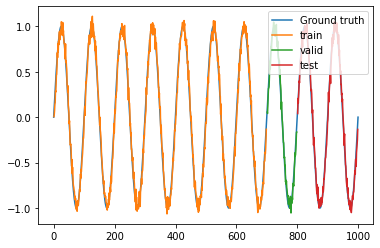

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 537.7191251313174
